In this notebook, the speaker classification task will be carried out. In particular, as illustrated in the task description, the wav2vec2.0 will be used as feature extractor, instead of the MFCC. 

In this notebook 3 different prediction models were applied to classify our data, in particular a Random Forest classifier, an SVM classifier and a NN classifier. 

In [7]:
import pandas as pd
import numpy as np
import os
import re
import random
import torch
import torchaudio
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import itertools
import datetime
import fairseq


from IPython.display import Audio
from rich.progress import track
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [8]:
%run utils_function_2.py

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [9]:
# importing df_total in which there are all the informations about the audio files

df_total = pd.read_csv('~/Voiseed_task/dev_clean/df_total')

In [10]:
df_total

,ID,Chapter,path,SEX,NAME
0,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,M,John Rose
1,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,M,John Rose
2,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,M,John Rose
3,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,M,John Rose
4,1272,128104,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,M,John Rose
...,...,...,...,...,...
2698,8842,304647,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,Mary J
2699,8842,304647,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,Mary J
2700,8842,304647,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,Mary J
2701,8842,304647,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...,F,Mary J


In [11]:
df_total_segmented = calculate_raw_signal_segment(df_total, 2)

Output()

In [13]:
df_total_segmented.head()

,raw_signal,ID,SEX,path
0,"[[tensor(0.0024), tensor(0.0021), tensor(0.002...",1272,M,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
1,"[[tensor(0.0283), tensor(0.0250), tensor(0.031...",1272,M,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
2,"[[tensor(-0.0002), tensor(-9.1553e-05), tensor...",1272,M,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
3,"[[tensor(0.0446), tensor(0.0475), tensor(0.036...",1272,M,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...
4,"[[tensor(-0.0007), tensor(6.1035e-05), tensor(...",1272,M,/home/pierobon/Voiseed_task/dev_clean/LibriSpe...


# Train-validation-test split

The split of the dataset needs to take into consideration the following concept: since we want to classify the speaker, in both train and test datasets we need all the speakers ID, but the audio segments, so what they are saying, needs to be different. Segmenting the original audio samples implies that the audio chunks are different from each other and, since each chapter is read by only one speaker we can simply divide the dataset using the sklearn function train_test_split

In [14]:
df_train_temp, df_test = train_test_split(df_total_segmented, test_size=0.2, stratify=df_total_segmented.ID)
df_train, df_validation = train_test_split(df_train_temp, test_size=0.15, stratify=df_train_temp.ID)

# Features extraction with wav2vec

As stated before, in this notebook we are not using the MFCC as a representation of the audio, but we will use the wav2vec2.0 pretrained on librispeech as feature extractor.

In [18]:
# Load the wav2vec model 

torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cp_path = '/home/pierobon/Voiseed_task/wav2vec2/wav2vec_large.pt'
#cp_path = '/home/pierobon/Voiseed_task/wav2vec_finetuned/wav2vec_small_10m.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp_path])
model = model[0].to(device)

2021-12-14 13:26:50 | INFO | fairseq.models.wav2vec.wav2vec | Wav2VecModel(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(8,), stride=(4,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (3): Sequential(
        (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm

In [19]:
# Extract embeddings by doing the mean for each w2v band (512) over the time dimension

df_embeddings_train = extract_w2v_mean(model, device, df_train)
df_embeddings_validation = extract_w2v_mean(model, device, df_validation)
df_embeddings_test = extract_w2v_mean(model, device, df_test)

Output()

Output()

Output()

In [31]:
# scale the embeddings

df_train_emb_scaled = scale_embedding(df_embeddings_train, df_embeddings_train)
df_validation_emb_scaled = scale_embedding(df_embeddings_validation, df_embeddings_train)
df_test_emb_scaled = scale_embedding(df_embeddings_test, df_embeddings_train)

StandardScaler()
StandardScaler()
StandardScaler()


In [38]:
x_train = df_train_emb_scaled[list(range(0, 512))].values
y_train = df_train_emb_scaled.ID
x_validation = df_validation_emb_scaled[list(range(0,512))].values
y_validation = df_validation_emb_scaled.ID
x_test = df_test_emb_scaled[list(range(0,512))].values
y_test = df_test_emb_scaled.ID


It's evident that now we are facing a multiclass classification problem. In the following section, 3 different classification models were applied to our data, in particular a Random Forest classifier, an SVM classifier and a NN classifier 

# Random forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rf = RandomForestClassifier(n_estimators=1000)

rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [34]:
# VALIDATION

y_train_pred = rf.predict(x_train)
print(classification_report(y_train, y_train_pred))
y_validation_pred = rf.predict(x_validation)
print(classification_report(y_validation, y_validation_pred))

              precision    recall  f1-score   support

          84       1.00      1.00      1.00       144
         174       1.00      1.00      1.00       148
         251       1.00      1.00      1.00       137
         422       1.00      1.00      1.00       159
         652       1.00      1.00      1.00       143
         777       1.00      1.00      1.00       138
        1272       1.00      1.00      1.00       139
        1462       1.00      1.00      1.00       138
        1673       1.00      1.00      1.00       150
        1919       1.00      1.00      1.00       144
        1988       1.00      1.00      1.00       142
        1993       1.00      1.00      1.00       144
        2035       1.00      1.00      1.00       139
        2078       1.00      1.00      1.00       148
        2086       1.00      1.00      1.00       145
        2277       1.00      1.00      1.00       132
        2412       1.00      1.00      1.00       144
        2428       1.00    

In [36]:
# TEST

y_test_pred = rf.predict(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          84       0.90      0.90      0.90        42
         174       0.90      0.98      0.93        44
         251       0.91      0.78      0.84        40
         422       0.92      0.96      0.94        47
         652       0.91      0.98      0.94        42
         777       0.92      0.88      0.90        41
        1272       0.80      0.98      0.88        41
        1462       0.83      0.83      0.83        41
        1673       0.93      0.98      0.96        44
        1919       0.82      0.95      0.88        42
        1988       0.83      0.69      0.75        42
        1993       0.89      0.72      0.79        43
        2035       0.97      0.95      0.96        41
        2078       0.90      1.00      0.95        43
        2086       0.88      0.86      0.87        43
        2277       0.92      0.92      0.92        38
        2412       0.87      0.93      0.90        42
        2428       0.93    

Analyzing these results we can observe that we have some problems in terms of recall for the speakers 1988, 1993, 5694 and 6345. Remembering the oulier analysis carried out int voiseed_task_1, even if we were using the MFCC, we had noticed a strange behaviour exaclty of the speakers 1988, 1993 and 6345. Thus we can impute this low recall to this fact.

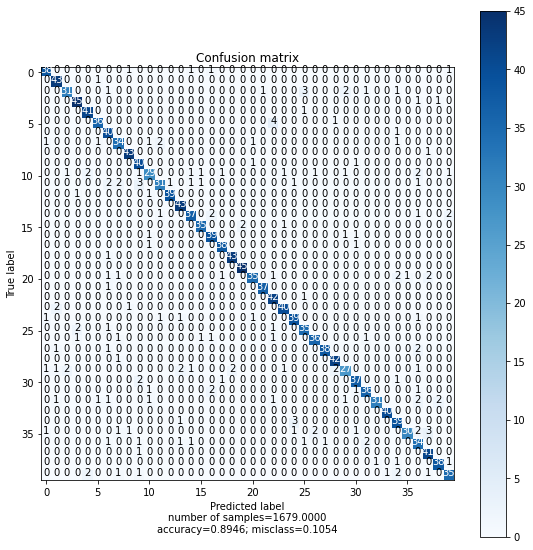

In [37]:
conf_mat = confusion_matrix(y_test, y_test_pred)


plot_confusion_matrix(conf_mat, None, title='Confusion matrix', cmap=None, normalize=False, file_name=None)

# SVC

In [39]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
svc = SVC(C = 10000, gamma='auto', kernel='rbf', break_ties = True, class_weight='balanced', decision_function_shape='ovr', random_state=42, verbose=True)
# these parameters were defined after a param_tuning using sklearn.model_selection GridSearchCV
svc.fit(x_train, y_train)

[LibSVM]

SVC(C=10000, break_ties=True, class_weight='balanced', gamma='auto',
    random_state=42, verbose=True)

In [40]:
# VALIDATION

y_train_pred = svc.predict(x_train)
print(classification_report(y_train, y_train_pred))
y_validation_pred = svc.predict(x_validation)
print(classification_report(y_validation, y_validation_pred))

              precision    recall  f1-score   support

          84       1.00      1.00      1.00       144
         174       1.00      1.00      1.00       148
         251       1.00      1.00      1.00       137
         422       1.00      1.00      1.00       159
         652       1.00      1.00      1.00       143
         777       1.00      1.00      1.00       138
        1272       1.00      1.00      1.00       139
        1462       1.00      1.00      1.00       138
        1673       1.00      1.00      1.00       150
        1919       1.00      1.00      1.00       144
        1988       1.00      1.00      1.00       142
        1993       1.00      1.00      1.00       144
        2035       1.00      1.00      1.00       139
        2078       1.00      1.00      1.00       148
        2086       1.00      1.00      1.00       145
        2277       1.00      1.00      1.00       132
        2412       1.00      1.00      1.00       144
        2428       1.00    

In [41]:
#TEST

y_test_pred = svc.predict(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          84       0.98      0.98      0.98        42
         174       0.96      1.00      0.98        44
         251       0.92      0.85      0.88        40
         422       0.98      1.00      0.99        47
         652       0.98      0.98      0.98        42
         777       0.97      0.95      0.96        41
        1272       0.91      1.00      0.95        41
        1462       0.93      0.93      0.93        41
        1673       1.00      0.93      0.96        44
        1919       1.00      0.98      0.99        42
        1988       0.86      0.88      0.87        42
        1993       1.00      0.95      0.98        43
        2035       1.00      0.95      0.97        41
        2078       1.00      0.98      0.99        43
        2086       0.95      0.95      0.95        43
        2277       1.00      0.95      0.97        38
        2412       0.98      0.98      0.98        42
        2428       0.97    

As we've seen before in the RF, the lowest F1 score is for the speaker 1988 which has a strange behaviour, similar to a background noise or a distortion.

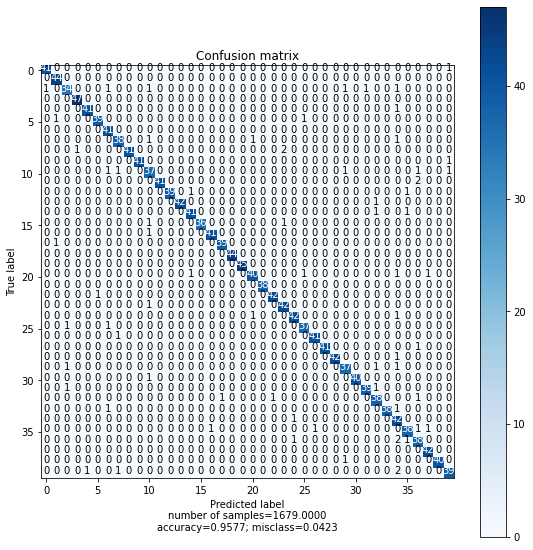

In [42]:
conf_mat = confusion_matrix(y_test, y_test_pred)


plot_confusion_matrix(conf_mat, None, title='Confusion matrix', cmap=None, normalize=False, file_name=None)

# Neural Network

The main idea here is to use the embeddings (calculated by doing the mean on the w2v representation) as the input of a NN. 
Since we're facing a multiclass classification problem a softmax function was applied in the last NN's layer, and SGD optimizer and cross-entropy loss were used. 

In [43]:
# extracting features

torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cp_path = '/home/pierobon/Voiseed_task/wav2vec2/wav2vec_large.pt'
#cp_path = '/home/pierobon/Voiseed_task/wav2vec_finetuned/wav2vec_small_10m.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp_path])
model = model[0].to(device)

2021-12-14 13:41:37 | INFO | fairseq.models.wav2vec.wav2vec | Wav2VecModel(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(8,), stride=(4,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (3): Sequential(
        (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm

In [44]:
df_embeddings_train = extract_w2v_mean(model, device, df_train)
df_embeddings_validation = extract_w2v_mean(model, device, df_validation)
df_embeddings_test = extract_w2v_mean(model, device, df_test)

Output()

Output()

Output()

In [45]:
# scale the embeddings

df_train_emb_scaled = scale_embedding(df_embeddings_train, df_embeddings_train)
df_validation_emb_scaled = scale_embedding(df_embeddings_validation, df_embeddings_train)
df_test_emb_scaled = scale_embedding(df_embeddings_test, df_embeddings_train)

StandardScaler()
StandardScaler()
StandardScaler()


In [46]:
# Define a dictionary which can be used for the encoding of the target values (ID of the speaker)

keys_list = df_embeddings_train.ID.unique()
values_list = range(40)
zip_iterator = zip(keys_list, values_list)

class2idx = dict(zip_iterator)
c = {v: k for k, v in class2idx.items()}

In [47]:
class Linear_classifier(torch.nn.Module):
    def __init__(self):
        super(Linear_classifier, self).__init__()
       
        self.lin1 = torch.nn.Linear(512, 256)  
        self.lin4 = torch.nn.Linear(256, 128)  
        #self.lin3 = torch.nn.Linear(128, 64)  
        self.lin2 = torch.nn.Linear(128, 40) 
        self.soft = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.tanh(self.lin1(x))
        x = torch.tanh(self.lin4(x))
        #x = torch.tanh(self.lin3(x))
        x = (self.lin2(x))
        #x = self.soft(x)
        return x

In [50]:
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Linear_classifier().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [51]:
linear_model = training_validation(model, df_train_emb_scaled, df_validation_emb_scaled, 64, 1000, 'Linear_classifier_2', True, class2idx)

Output()

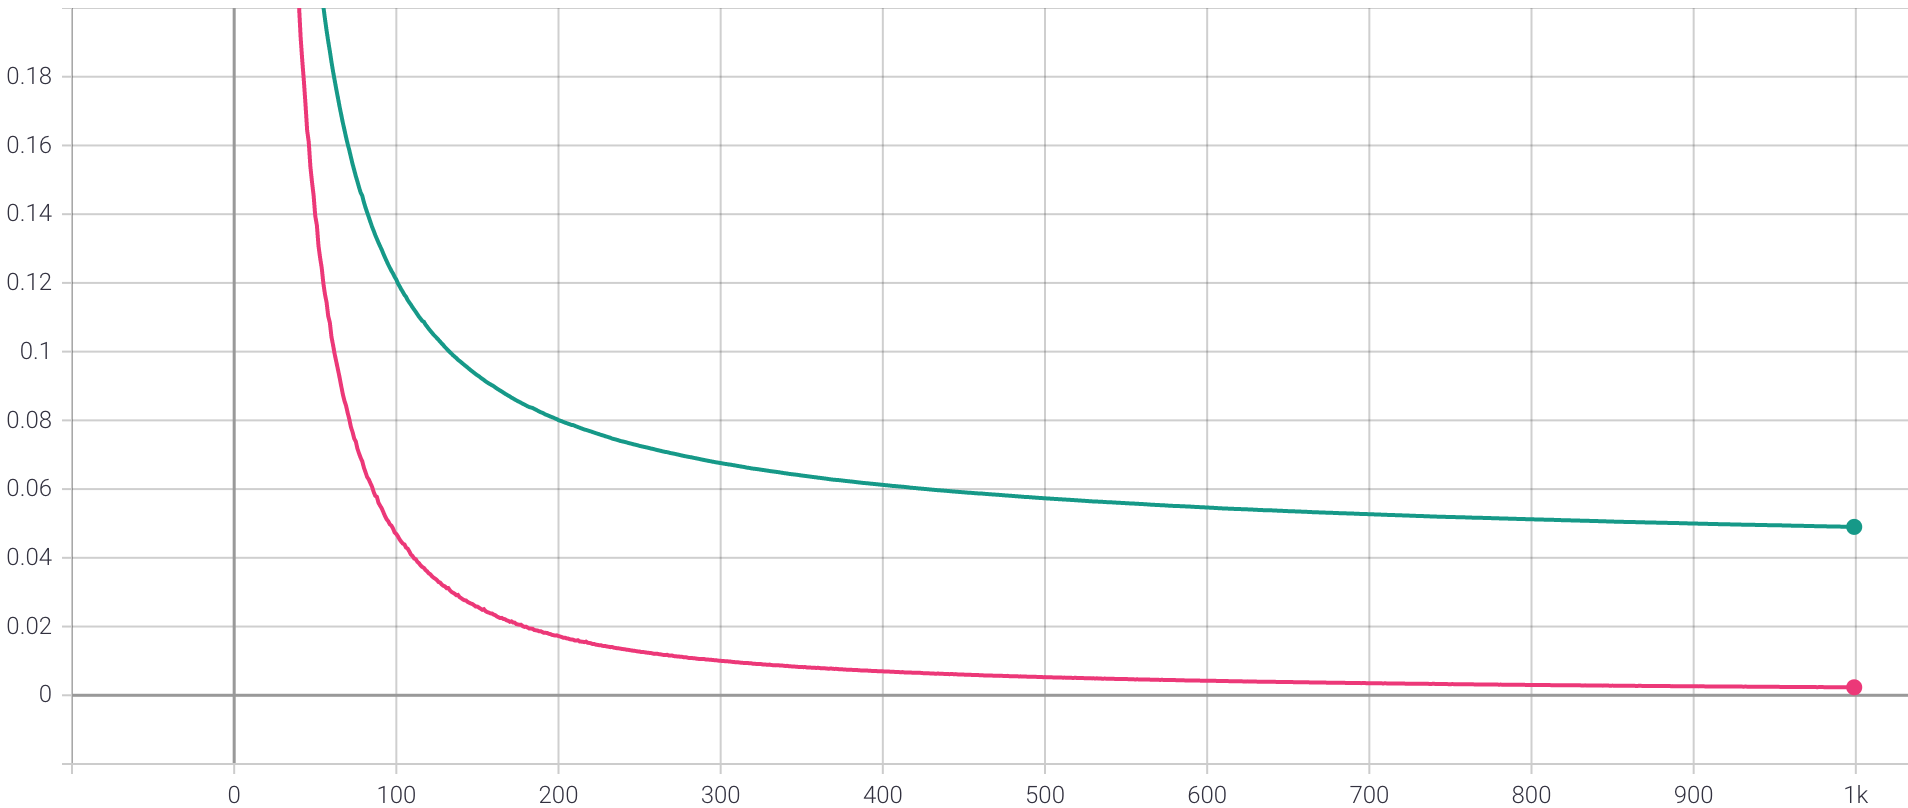

The chart above is a screen from tensorboard, the gree line is the train_loss_mean and the blue line is the validation_loss_mean. The x-axis represents the training epochs while the y-axis the loss.

As we can see, the model is diminishing the error at each epochs and there are not overfitting problems

In [53]:
prediction = testing(df_test_emb_scaled, linear_model, class2idx)

In [55]:
print(classification_report(prediction.y_true, prediction.y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       1.00      1.00      1.00        45
           2       1.00      1.00      1.00        43
           3       0.97      0.97      0.97        40
           4       1.00      0.98      0.99        42
           5       0.93      0.98      0.95        42
           6       0.95      1.00      0.98        42
           7       1.00      1.00      1.00        38
           8       0.98      0.98      0.98        41
           9       1.00      0.98      0.99        42
          10       1.00      1.00      1.00        43
          11       1.00      0.93      0.96        42
          12       1.00      1.00      1.00        42
          13       1.00      1.00      1.00        40
          14       1.00      1.00      1.00        47
          15       0.98      1.00      0.99        44
          16       1.00      1.00      1.00        44
          17       0.97    

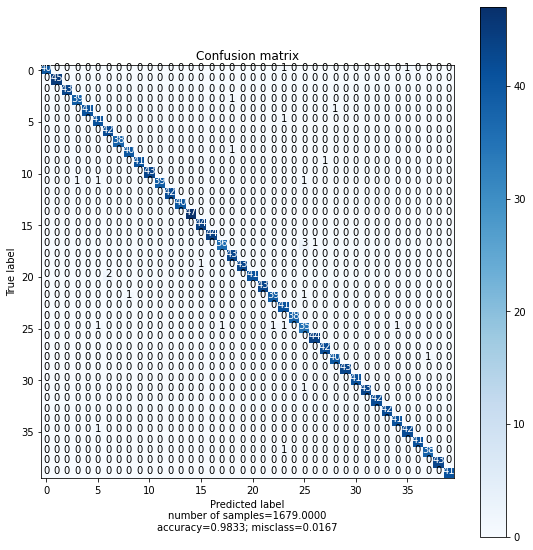

In [54]:
conf_mat = confusion_matrix(prediction.y_true, prediction.y_pred)


plot_confusion_matrix(conf_mat, None, title='Confusion matrix', cmap=None, normalize=False, file_name=None)

As we've seen with the gender classification task, the model which obtained the best results on the test set is the NN (accuracy = 0,98).

# RNN

We have also tried to calculate the embeddings by using the last hidden state of a gru. Unfortunately, the results generated from these embeddings were worse than the ones obtained with the embeddings in which the mean of each w2v band was done.